In [1]:
%matplotlib widget

import os
import re
import typing

import torch

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

In [2]:
def load_saved_tensor(path: str) -> torch.Tensor:
    tensor = torch.load(path)
    if isinstance(tensor, torch.nn.parameter.Parameter):
        tensor = torch.nn.utils.convert_parameters.parameters_to_vector(tensor).reshape(tensor.shape)
    tensor = tensor.detach().to("cpu")
    return tensor

In [3]:
runs_fields = {}

filter_base_path = os.path.join(".", "runs", "resolutions_filter")
filter_dir_name_list = next(os.walk(filter_base_path))[1]
filter_name_pattern: re.Pattern = re.compile(r"dataset.img_size=(\d+), noise_level=((?:\d\.\d+)|(?:\de-?\d+))")
filter_run_name_data_list = map(lambda dir_name: filter_name_pattern.fullmatch(dir_name), filter_dir_name_list)
filter_clean_run_name_data_list = typing.cast(typing.Generator[re.Match[str], None, None], filter(lambda x: x!=None, filter_run_name_data_list))
for run_name_data in filter_clean_run_name_data_list:
    for name in ["coefficients", "delta", "pi", "gamma"]:
        path = os.path.join(".", "runs", "resolutions_filter", f"dataset.img_size={int(run_name_data.group(1))}, noise_level={float(run_name_data.group(2))}", name+".pt")
        runs_fields[f"filter_s{run_name_data.group(1)}_n{run_name_data.group(2).replace('.', '')}_{name}"] = load_saved_tensor(path)

svd_base_path = os.path.join(".", "runs", "resolutions_svd")
svd_dir_name_list = next(os.walk(svd_base_path))[1]
svd_name_pattern: re.Pattern = re.compile(r"model=svd, dataset.img_size=(\d+), noise_level=((?:\d\.\d+)|(?:\de-?\d+))")
svd_run_name_data_list = map(lambda dir_name: svd_name_pattern.fullmatch(dir_name), svd_dir_name_list)
svd_clean_run_name_data_list = typing.cast(typing.Generator[re.Match[str], None, None], filter(lambda x: x!=None, svd_run_name_data_list))
for run_name_data in svd_clean_run_name_data_list:
    for name in ["coefficients", "delta", "pi", "gamma", "singular_values"]:
        path = os.path.join(".", "runs", "resolutions_svd", f"model=svd, dataset.img_size={int(run_name_data.group(1))}, noise_level={float(run_name_data.group(2))}", name+".pt")
        runs_fields[f"svd_s{run_name_data.group(1)}_n{run_name_data.group(2).replace('.', '')}_{name}"] = load_saved_tensor(path)

runs = typing.cast(typing.Any, type("Runs", (object,), runs_fields))

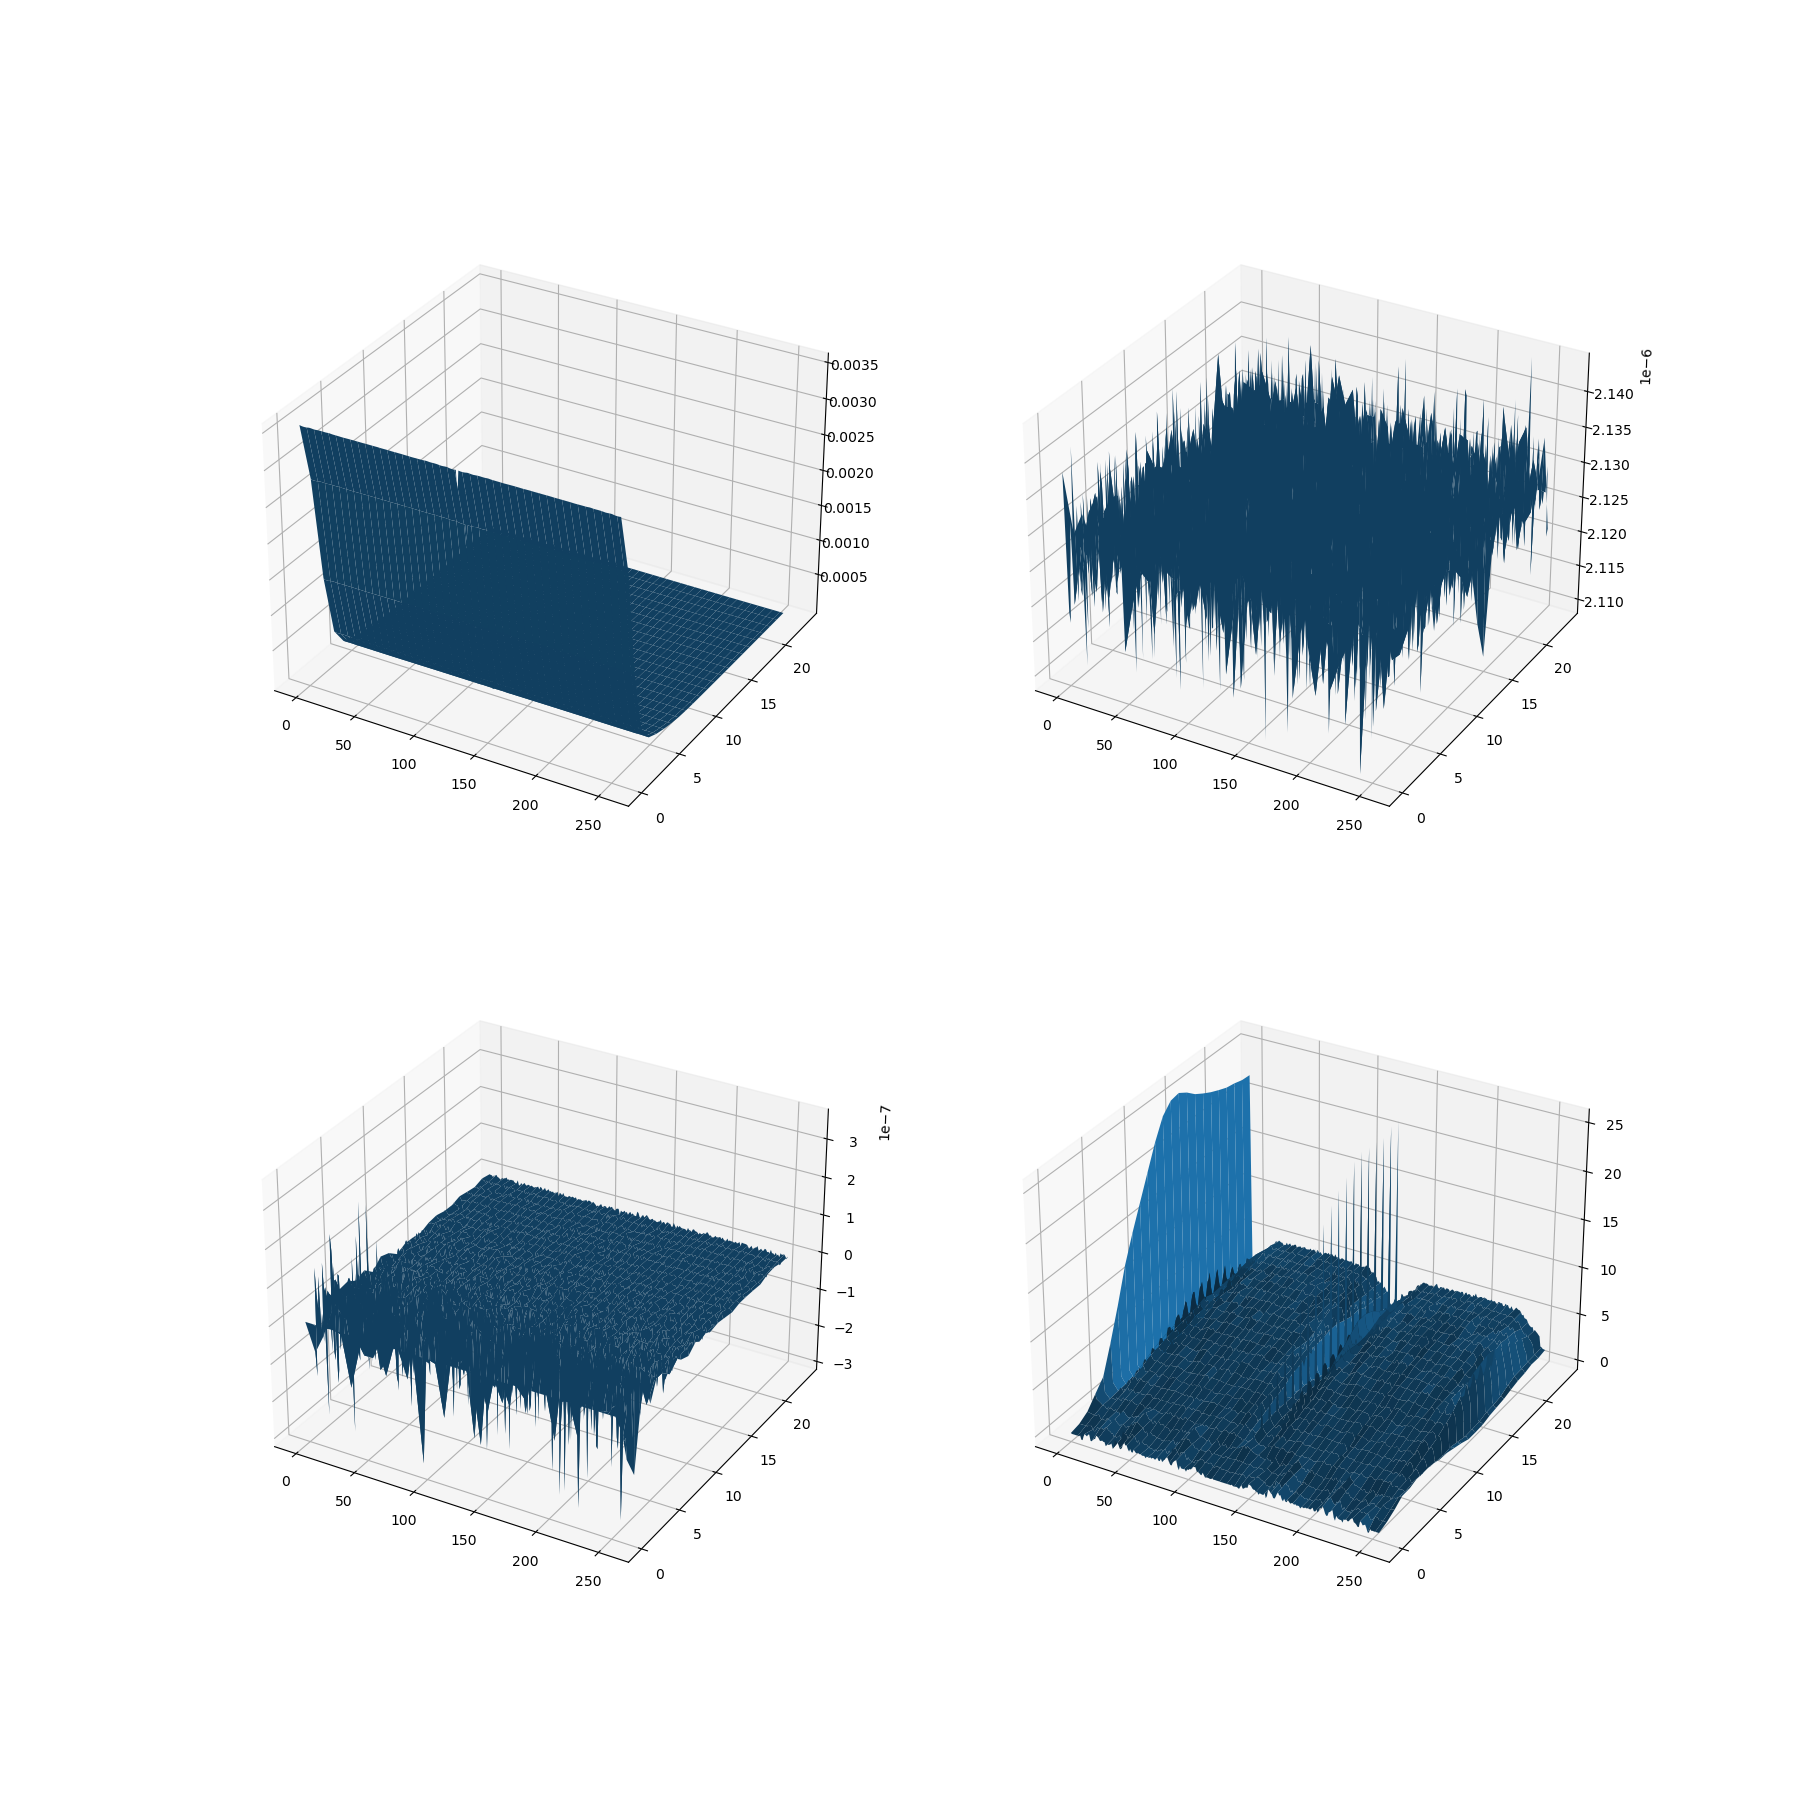

In [4]:
plt.subplots(2, 2, figsize=(18, 18))

axes = typing.cast(mpl_toolkits.mplot3d.Axes3D, plt.subplot(2, 2, 1, projection="3d"))
axes.plot_surface(*torch.meshgrid(torch.arange(runs.filter_s32_n001_pi.shape[0]), torch.arange(runs.filter_s32_n001_pi.shape[1]), indexing="ij"), runs.filter_s32_n001_pi.numpy())

axes = typing.cast(mpl_toolkits.mplot3d.Axes3D, plt.subplot(2, 2, 2, projection="3d"))
axes.plot_surface(*torch.meshgrid(torch.arange(runs.filter_s32_n001_delta.shape[0]), torch.arange(runs.filter_s32_n001_delta.shape[1]), indexing="ij"), runs.filter_s32_n001_delta.numpy())

axes = typing.cast(mpl_toolkits.mplot3d.Axes3D, plt.subplot(2, 2, 3, projection="3d"))
axes.plot_surface(*torch.meshgrid(torch.arange(runs.filter_s32_n001_gamma.shape[0]), torch.arange(runs.filter_s32_n001_gamma.shape[1]), indexing="ij"), runs.filter_s32_n001_gamma.numpy())

axes = typing.cast(mpl_toolkits.mplot3d.Axes3D, plt.subplot(2, 2, 4, projection="3d"))
axes.plot_surface(*torch.meshgrid(torch.arange(runs.filter_s32_n001_coefficients.shape[0]), torch.arange(runs.filter_s32_n001_coefficients.shape[1]), indexing="ij"), runs.filter_s32_n001_coefficients.numpy())

plt.show()

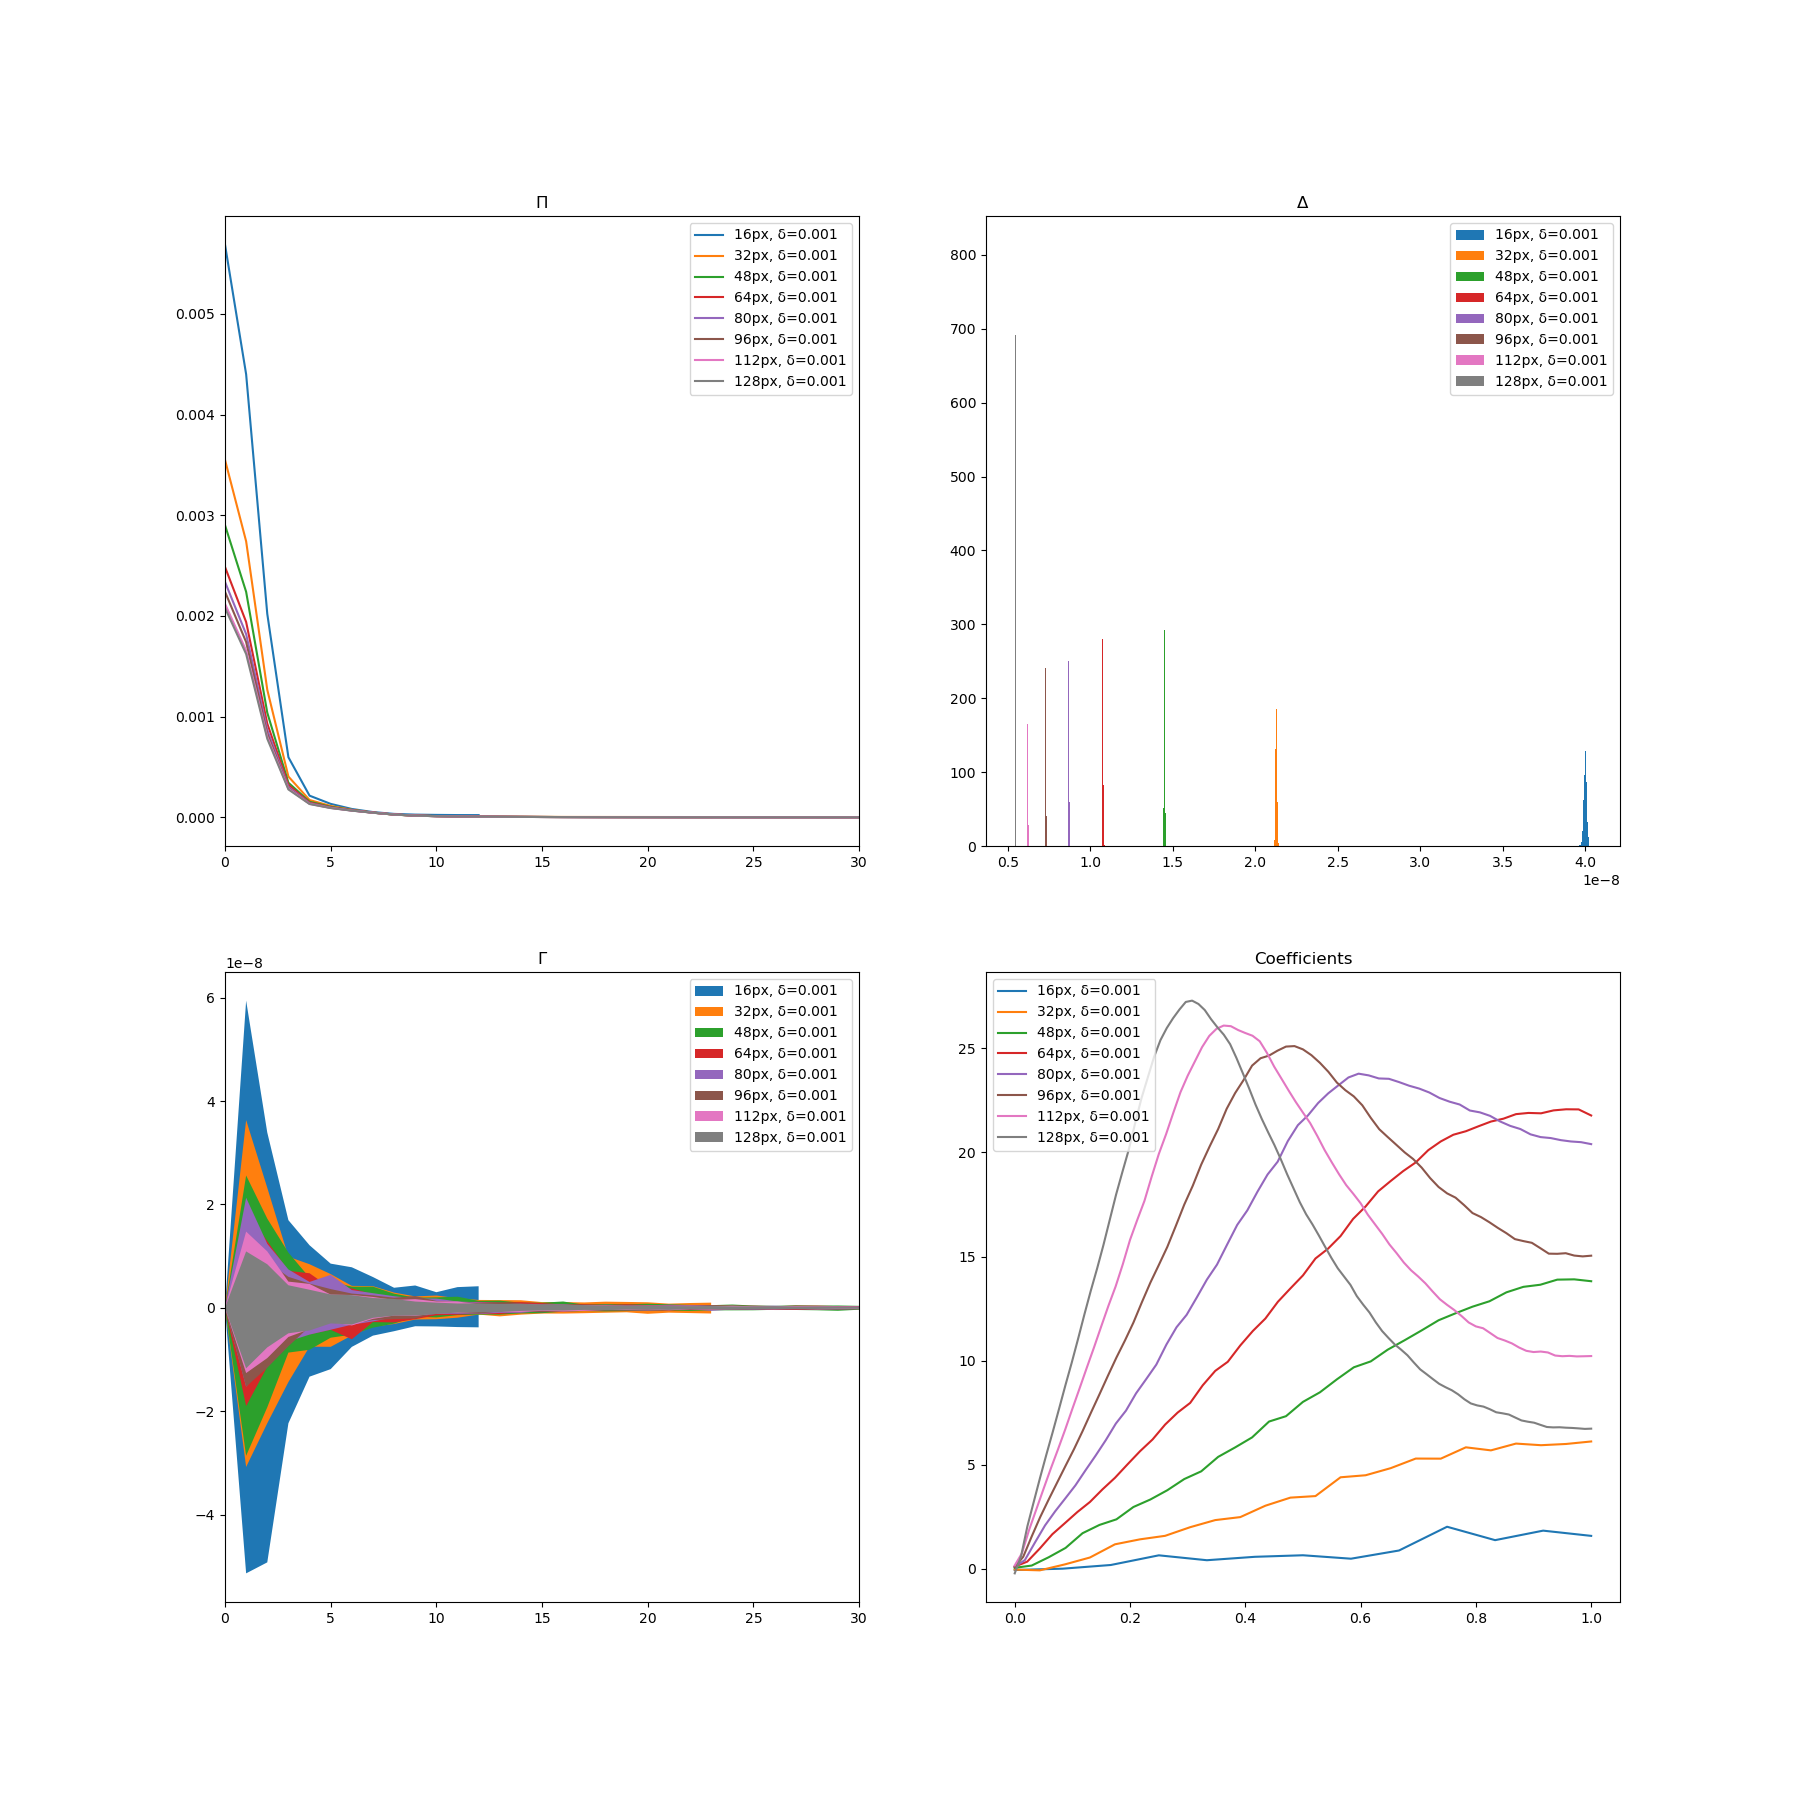

In [5]:
plt.subplots(2, 2, figsize=(18, 18))

axes = plt.subplot(2, 2, 1)
axes.set_title("Π")
for res in [16,32,48,64,80,96,112,128]:
    pi = getattr(runs, f"filter_s{res}_n0001_pi")
    axes.plot(pi[0], label=f"{res}px, δ=0.001")
axes.legend()
axes.set_xlim(0.0, 30.0)

axes = plt.subplot(2, 2, 2)
axes.set_title("Δ")
for res in [16,32,48,64,80,96,112,128]:
    delta = getattr(runs, f"filter_s{res}_n0001_delta")
    axes.hist(delta.flatten(), 100, label=f"{res}px, δ=0.001")
axes.legend()

axes = plt.subplot(2, 2, 3)
axes.set_title("Γ")
for res in [16,32,48,64,80,96,112,128]:
    gamma = getattr(runs, f"filter_s{res}_n0001_gamma")
    axes.fill_between(torch.arange(gamma.shape[1]), torch.min(gamma.mT, dim=1)[0], torch.max(gamma.mT, dim=1)[0], label=f"{res}px, δ=0.001")
axes.legend()
axes.set_xlim(0.0, 30.0)

axes = plt.subplot(2, 2, 4)
axes.set_title("Coefficients")
for idx, res in enumerate([16,32,48,64,80,96,112,128]):
    coefficients = getattr(runs, f"filter_s{res}_n0001_coefficients")
    x = torch.linspace(0.0, 1.0, coefficients[1:].shape[1])
    #x = torch.arange(coefficients[1:].shape[1])
    axes.plot(x, coefficients[63:64].mT, color=plt.rcParams["axes.prop_cycle"].by_key()["color"][idx], label=f"{res}px, δ=0.001")
    #axes.plot(x, coefficients[0:1].mT, color=plt.rcParams["axes.prop_cycle"].by_key()["color"][idx], label=f"{res}px, δ=0.001")
    #axes.plot(x, coefficients[1:].mT, color=plt.rcParams["axes.prop_cycle"].by_key()["color"][idx])
axes.legend()

plt.show()

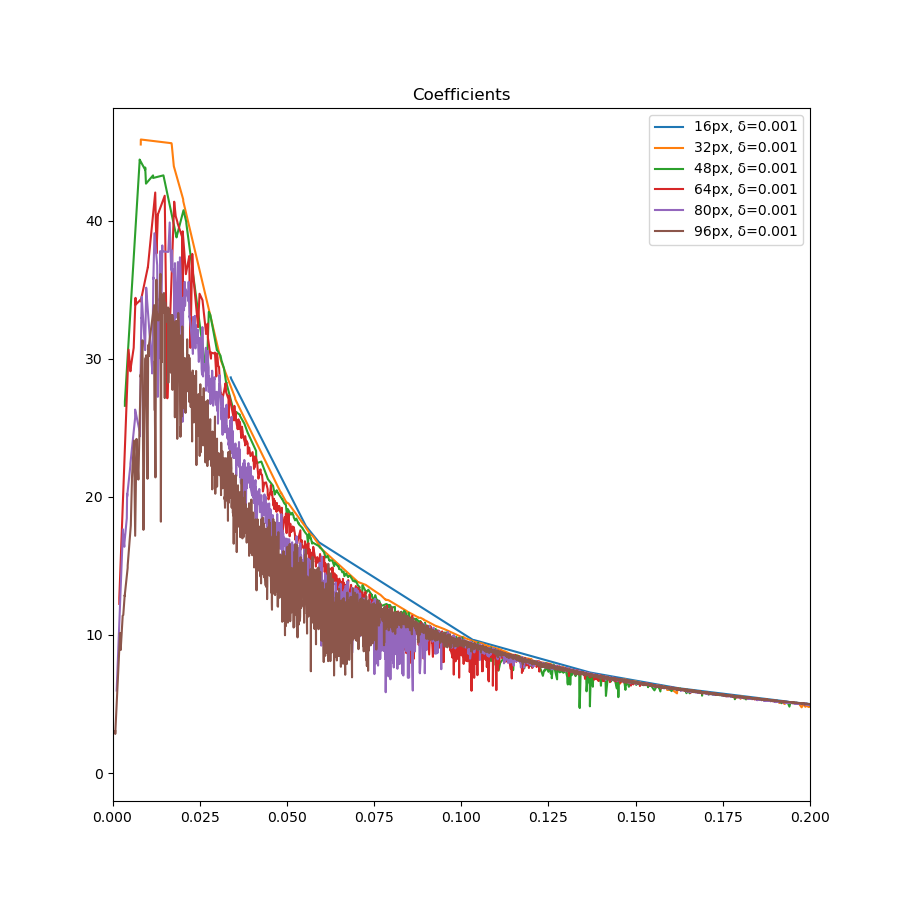

In [6]:
plt.subplots(1, 1, figsize=(9, 9))

axes = plt.subplot(1, 1, 1)
axes.set_title("Coefficients")
for idx, res in enumerate([16,32,48,64,80,96]):
    coefficients = getattr(runs, f"svd_s{res}_n0001_coefficients")
    singular_values = getattr(runs, f"svd_s{res}_n0001_singular_values")
    axes.plot(singular_values, coefficients, label=f"{res}px, δ=0.001")
axes.legend()
axes.set_xlim(0.0, 0.2)

plt.show()

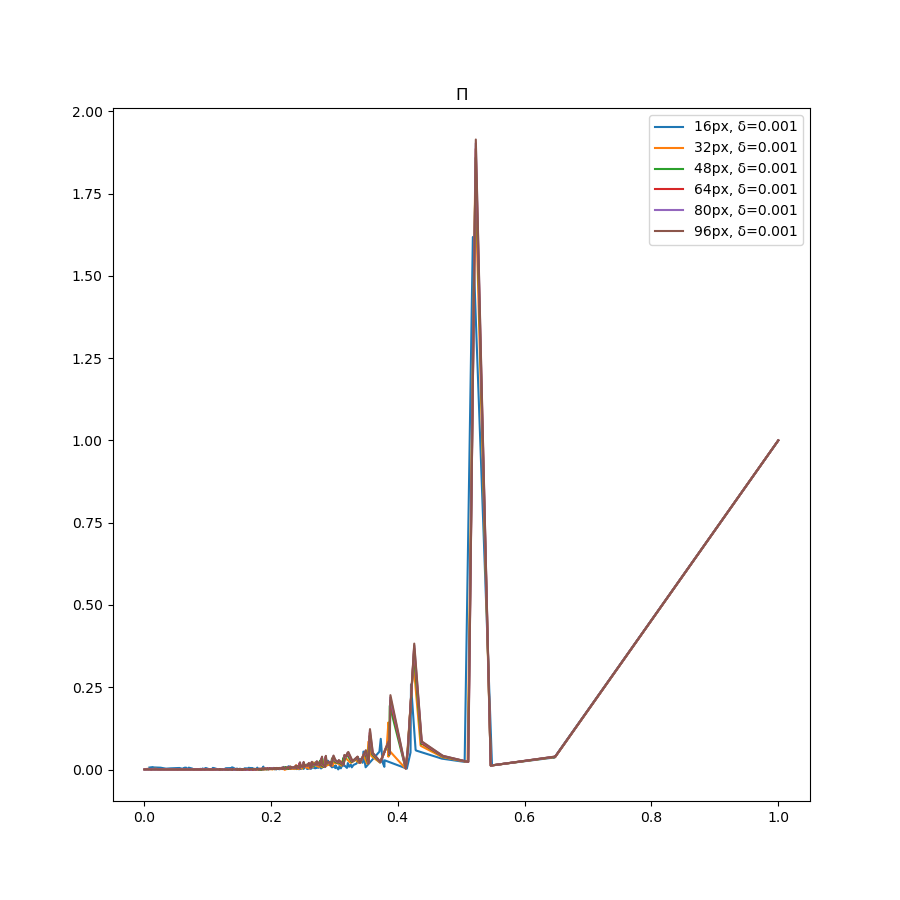

In [20]:
plt.subplots(1, 1, figsize=(9, 9))

axes = plt.subplot(1, 1, 1)
axes.set_title("Π")
for idx, res in enumerate([16,32,48,64,80,96]):
    pi = getattr(runs, f"svd_s{res}_n0001_pi")
    singular_values = getattr(runs, f"svd_s{res}_n0001_singular_values")
    axes.plot(singular_values/singular_values.max(), pi/pi[0], label=f"{res}px, δ=0.001")
axes.legend()
#axes.set_xlim(0.0, 0.2)

plt.show()